步骤:
1. 导入数据
2. 初始化参数
3. 正向传播
4. 计算成本
5. 反向传播
6. 更新参数
7. 循环3 ~ 6

In [1]:
# 引入依赖包
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [2]:
# 导入数据
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 训练数据特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 训练数据标签

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 测试数据特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 测试数据标签

    classes = np.array(test_dataset["list_classes"][:]) # 类别list
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
# 导入图片
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

In [4]:
# 显示图片相关信息
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("训练样本数量: " + str(m_train))
print ("测试样本数量: " + str(m_test))
print ("每张图片的大小: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig 形状: " + str(train_x_orig.shape))
print ("train_y 形状: " + str(train_y.shape))
print ("test_x_orig 形状: " + str(test_x_orig.shape))
print ("test_y 形状: " + str(test_y.shape))

训练样本数量: 209
测试样本数量: 50
每张图片的大小: (64, 64, 3)
train_x_orig 形状: (209, 64, 64, 3)
train_y 形状: (1, 209)
test_x_orig 形状: (50, 64, 64, 3)
test_y 形状: (1, 50)


In [5]:
#将图片转成矩阵 --> 矩阵中一列对应一张图片
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# 处理特征值 --> 使特征介于0和1之间
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x 的形状: " + str(train_x.shape))
print ("test_x 的形状: " + str(test_x.shape))

train_x 的形状: (12288, 209)
test_x 的形状: (12288, 50)


In [6]:
# 定义 sigmoid 模型
def sigmoid(Z):
    """
    使用 numpy 实现 sigmoid 函数
    
    Arguments:
    Z -- numpy array
    
    Returns:
    A -- sigmoid(z) 函数输出, 与 Z 形状相同
    cache -- 缓存 Z, 以后在反向传播中使用
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

# sigmoid 函数求导
def sigmoid_backward(dA, cache):
    """
    对单个 sigmoid 节点实现反向传播.
    
    Arguments:
    dA -- 成本 cost 对 A 的梯度
    cache -- 'Z' 之前缓存的线性函数值
    Returns:
    dZ -- 成本 cost 对 Z 的梯度
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [7]:
# 定义 relu 模型
def relu(Z):
    """
    实现 RELU 函数
    
    Arguments:
    Z -- 线性函数输出
    Returns:
    A -- RELU 函数输出, 与 Z 形状相同
    cache -- python 字典, 缓存了 Z
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

# relu函数求导
def relu_backward(dA, cache):
    """
    对单个 RELU 节点实现反向传播
    
    Arguments:
    dA -- 成本 cost 对 A 的梯度
    cache -- 缓存了 Z
    Returns:
    dZ -- 成本 cost 对 Z 的梯度
    """
    
    Z = cache
    dZ = np.array(dA, copy=True)
    
    # 当 z <= 0, dZ 等于 0. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


In [8]:
# 初始化参数
def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- 定义神经网络形状的 python array (list)
    
    Returns:
    parameters -- python 字典, 缓存了参数 "W1", "b1", ..., "WL", "bL":
                    Wl -- 形状是 (layer_dims[l], layer_dims[l-1]) 的权重矩阵
                    bl -- 形状是 (layer_dims[l], 1) 的偏置向量
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # 神经网络层数

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters 

In [9]:
# 计算线性函数 Z 的值 --> Z = W*A + b
def linear_forward(A, W, b):
    """
    实现单层线性部分的正向传播
    
    Arguments:
    A -- 上层(或输入)的激活值,形状: (上层维度, 样本数量)
    W -- 权重矩阵, numpy array 形状: (当前层维度, 上层维度)
    b -- 偏置向量, numpy array 形状: (当前层维度, 1)
    Returns:
    Z -- 激活函数输入, 也称为 pre-activation parameter 
    cache -- 一个 python 字典,保存 "A", "W" and "b" ; 
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

# 计算激活函数 A 的值 --> A = g(Z)
def linear_activation_forward(A_prev, W, b, activation):
    """
    对 LINEAR->ACTIVATION 层实现正向传播
    
    Arguments:
    A_prev -- 上层(或输入)的激活值,形状: (上层维度, 样本数量)
    W -- 权重矩阵, numpy array 形状: (当前层维度, 上层维度)
    b -- 偏置向量, numpy array 形状: (当前层维度, 1)
    activation -- 激活函数类型: "sigmoid" 或 "relu"
    Returns:
    A -- 激活函数输出, 也称为 the post-activation value 
    cache -- 一个 python 字典 保存 "linear_cache" 和 "activation_cache";
    """
    
    if activation == "sigmoid":
        # 输入: "A_prev, W, b". 输出: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # 输入: "A_prev, W, b". 输出: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [10]:
# 正向传播
def L_model_forward(X, parameters):
    """
    对[LINEAR->RELU]*(L-1)->LINEAR->SIGMOID实现正向传播
    
    Arguments:
    X -- data, numpy array 形状 (特征数量, 样本数量)
    parameters -- initialize_parameters() 初始化函数输出
    
    Returns:
    AL -- last post-activation value
    caches -- 缓存列表 保存:
                每一个 linear_relu_forward() (有 L-1 个, 索引从 0 到 L-2) 的缓存
                linear_sigmoid_forward() (有一个, 索引 L-1) 的缓存
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # 神经网络层数
    
    # 实现 [LINEAR -> RELU]*(L-1). 添加 "cache" 到 "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = "relu")
        caches.append(cache)
    
    # 实现 LINEAR -> SIGMOID. 添加 "cache" 到 "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

In [11]:
# 计算成本
def compute_cost(AL, Y):
    """
    实现成本计算
    
    Arguments:
    AL -- 对每个样本预测的概率向量, 形状 (1, 样本数量)
    Y -- 标签向量 (for example: containing 0 if non-cat, 1 if cat), 形状 (1, 样本数量)
    Returns:
    cost -- 交叉熵成本
    """
    
    m = Y.shape[1]

    # 根据 aL 和 y计算损失.
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # 确保成本的形状是我们期望的(e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

In [12]:
# 计算线性函数 Z 的导数 --> dW, db, dA_prev
def linear_backward(dZ, cache):
    """
    对第l层的线性部分实现反向传播
    
    Arguments:
    dZ -- 成本对当前第 l 层线性输出的梯度
    cache -- tuple, 当前层正向传播时保存的: (A_prev, W, b) 
    Returns:
    dA_prev -- 成本对第 l-1 层激活值的梯度, 与 A_prev 形状相同
    dW -- 成本对当前第 l 层权重 W 的梯度,与 W 形状相同
    db -- 成本对当前第 l 层偏置 b 的梯度,与 b 形状相同
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

# 计算激活函数 A 的导数 --> dZ
def linear_activation_backward(dA, cache, activation):
    """
    对 LINEAR->ACTIVATION 层实现反向传播
    
    Arguments:
    dA -- 当前第 l 层 post-activation 的梯度
    cache -- tuple: (linear_cache, activation_cache)
    activation -- 激活函数: "sigmoid" 或 "relu"
    
    Returns:
    dA_prev -- 成本对第 l-1 层激活函数的梯度, 与 A_prev 形状相同
    dW -- 成本对当前第 l 层的权重 W 的梯度, 与 W 形状相同
    db -- 成本对当前第 l 层的偏置 b 的梯度,与 b 形状相同
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [13]:
# 反向传播
def L_model_backward(AL, Y, caches):
    """
    对  [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID 实现反向传播

    Arguments:
    AL -- 概率向量, 正向传播的输出 (L_model_forward())
    Y -- 标签向量 (containing 0 if non-cat, 1 if cat)
    caches -- 缓存列表 保存:
                每一个 linear_activation_forward() with "relu" (有 L-1 个, 索引从 0 到 L-2) 的缓存
                linear_activation_forward() with "sigmoid" (有 1 个, 索引 L-1) 的缓存
    
    Returns:
    grads -- 梯度字典:
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # 层数
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # 令 Y 的形状与 AL 相同
    
    # 初始化反向传播
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # 第 L 层 (SIGMOID -> LINEAR) 的梯度. 输入: "AL, Y, caches". 输出: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        # 第 l 层: (RELU -> LINEAR) 的梯度.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [14]:
# 更新参数
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数

    Arguments:
    parameters -- 保存参数的 python 字典 
    grads -- 保存梯度的 python 字典,L_model_backward 的输出
    
    Returns:
    parameters -- 保存更新后参数的 python 字典
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # 神经网络的层数

    # 使用循环更新每一个参数
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [15]:
# 训练
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    实现一个 L 层神经网络: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.

    Arguments:
    X -- 数据, numpy array 形状: (样本数量, 行像素 * num_px * 3)
    Y -- 标签向量 (containing 0 if cat, 1 if non-cat), 形状: (1, 样本数量)
    layers_dims -- 含有输入维度和每层维度的列表, length (层数 + 1).
    learning_rate -- 梯度下降学习速率
    num_iterations -- 梯度下降次数
    print_cost -- 是否打印成本(每 100 个循环打印一次成本)
    
    Returns:
    parameters -- 模型学习的参数,可以用来预测
    """

    np.random.seed(1)
    costs = []                         # 记录成本
    
    # 初始化参数.
    parameters = initialize_parameters(layers_dims)
    
    # 循环 (梯度下降)
    for i in range(0, num_iterations):

        # 正向传播: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # 计算成本.
        cost = compute_cost(AL, Y)
    
        # 反向传播.
        grads = L_model_backward(AL, Y, caches)
 
        # 更新参数.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # 每 100 次循环打印一次成本
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # 绘出成本曲线
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [16]:
# 准确率计算
def predict(X, y, parameters):
    """
    使用 L 层神经网络预测结果

    Arguments:
    X -- 想要预测的样本数据
    parameters -- 训练模型的参数
    
    Returns:
    p -- 对样本 X 的预测
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # 神经网络的层数
    p = np.zeros((1,m))
    
    # 正向传播
    probas, caches = L_model_forward(X, parameters)

    
    # 将预测概率转换成 0/1
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #打印结果
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


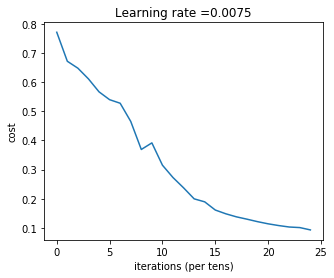

In [17]:
# 开始训练
layers_dims = [12288, 20, 7, 5, 1] #  5 层网络,输入(第0层) 12288 维,第1层 20 维, 第2层 7 维,第3层 5 维,第4层 1 维
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [27]:
# 计算训练准确率
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.985645933014


In [28]:
# 计算测试准确率
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Accuracy: 1.0
y = 1.0, your L-layer model predicts a "cat" picture.


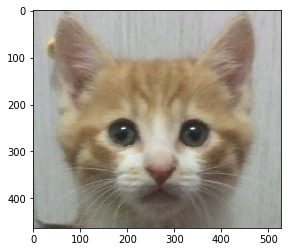

In [29]:
#指定图片测试
my_image = "maoqiu.jpg"
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")